In [1]:
import gymnasium as gym
from gymnasium import spaces
import json
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.backends.backend_agg import FigureCanvasAgg

from stable_baselines3 import A2C, PPO, DQN
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker
from sb3_contrib.common.maskable.callbacks import MaskableEvalCallback

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.logger import configure
from stable_baselines3.common.env_checker import check_env

In [2]:
from scheduler_env.customEnv_repeat import SchedulingEnv

In [3]:
import warnings
# 특정 경고를 무시하도록 필터를 설정합니다.
warnings.filterwarnings("ignore", category=Warning)

In [6]:
env = SchedulingEnv(machine_config_path= "instances/Machines/v0-2.json", job_config_path = "instances/figure/job3.json", job_repeats_params = [(1, 1)] * 12)

In [7]:
step = 0
obs, info = env.reset()
#print(info['schedule_buffer'])

while True:
    step += 1
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    # print(f"action : {action // 3}, {action % 3}")
    # print(info['schedule_buffer'])
    # env.visualize_graph()
    done = terminated or truncated
    
    
    if done:
        print("Goal reached!", "final score=", reward)
        print('finish_time', info['finish_time'])
        print('machine_operation_rate', info['machine_operation_rate'])
        print('job_deadline', info['job_deadline'])
        print('job_time_exceeded', info['job_time_exceeded'])
        print('current_repeats', info['current_repeats'])
        print(env.target_time)
        env.render()
        break

TypeError: 'int' object is not subscriptable

In [6]:
# job_paths와 machine_paths를 포함하는 목록
job_paths = ["instances/Jobs/v0-12-repeat-easy.json"]
machine_paths = ["instances/Machines/v0-8.json"]

def make_env(job_path, machine_path, test_mode, job_repeats_params):
    def _init():
        env = SchedulingEnv(job_config_path=job_path, machine_config_path=machine_path, job_repeats_params = job_repeats_params, test_mode = test_mode)
        return Monitor(env)
    return _init

envs = [make_env(job_paths[0], machine_paths[0], False, [(3, 1)]*12), make_env(job_paths[0], machine_paths[0], False, [(3, 1)]*12)]

vec_env = SubprocVecEnv(envs)

In [7]:
log_path = "./logs/tmp/1"
# set up logger
new_logger = configure(log_path, ["stdout", "csv", "tensorboard"])

# Create the evaluation environment
eval_env = SubprocVecEnv([make_env(job_paths[0], machine_paths[0], False, [(3, 1)]*12)])

# Create the EvalCallback
eval_callback = MaskableEvalCallback(eval_env, best_model_save_path=log_path,
                                     log_path=log_path, eval_freq=10000,
                                     deterministic=True, render=False)

Logging to ./logs/tmp/1


In [8]:
params = {
    "policy_kwargs": dict(net_arch=[dict(pi=[256, 64], vf=[256, 64])]),
    "gamma": 1.0,
    "clip_range": 0.1,
    "n_steps": 4096,
    "learning_rate": 0.0007,
}

model = MaskablePPO('MultiInputPolicy', vec_env,
                    policy_kwargs=params["policy_kwargs"],
                    verbose=1)
model.set_logger(new_logger)
model.learn(1_000_000, callback=eval_callback)

Using cpu device


/Users/chiyeong/Documents/projects/winter-study-reinforcement/RL-Scheduler/.venv/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.action_masks to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.action_masks` for environment variables or `env.get_wrapper_attr('action_masks')` that will search the reminding wrappers.
  logger.warn(
/Users/chiyeong/Documents/projects/winter-study-reinforcement/RL-Scheduler/.venv/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.action_masks to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.action_masks` for environment variables or `env.get_wrapper_attr('action_masks')` that will search the reminding wrappers.
  logger.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93.3     |
|    ep_rew_mean     | 17.8     |
| time/              |          |
|    fps             | 848      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 93.1        |
|    ep_rew_mean          | 14.6        |
| time/                   |             |
|    fps                  | 634         |
|    iterations           | 2           |
|    time_elapsed         | 12          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.017080447 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.2        |
|    explained_variance   | 0.00572     |
|    learning_rate        | 0.

/Users/chiyeong/Documents/projects/winter-study-reinforcement/RL-Scheduler/.venv/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.action_masks to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.action_masks` for environment variables or `env.get_wrapper_attr('action_masks')` that will search the reminding wrappers.
  logger.warn(


Eval num_timesteps=20000, episode_reward=10.02 +/- 4.67
Episode length: 93.40 +/- 5.99
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 93.4        |
|    mean_reward          | 10          |
| time/                   |             |
|    total_timesteps      | 20000       |
| train/                  |             |
|    approx_kl            | 0.013327517 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.12       |
|    explained_variance   | 0.843       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.228       |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0226     |
|    value_loss           | 1.88        |
-----------------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93.4     |
|    ep_rew_mean     | 18.7     |

In [9]:
env1 = SchedulingEnv(machine_config_path= "instances/Machines/v0-8.json", job_config_path = "instances/Jobs/v0-12-repeat-easy.json", job_repeats_params = [(3, 1)] * 12, test_mode = True)
env2 = SchedulingEnv(machine_config_path= "instances/Machines/v0-8.json", job_config_path = "instances/Jobs/v0-12-repeat-easy.json", job_repeats_params = [(3, 1)] * 12, test_mode = False)

custom_env = [env1, env2]

Current Repeats			:	[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Goal reached! Final score	:	33.10
Total revenue			:	2400.00 - 1605.50 = 794.50
Sum of Costs			:	1605.50
Cost Deadline			:	617.50
Cost Hole			:	48.00
Cost Processing			:	480.00
Cost Makespan			:	460.00
Finish Time / Target Time	:	4600 / 3000
Average Tardiness:	175.00


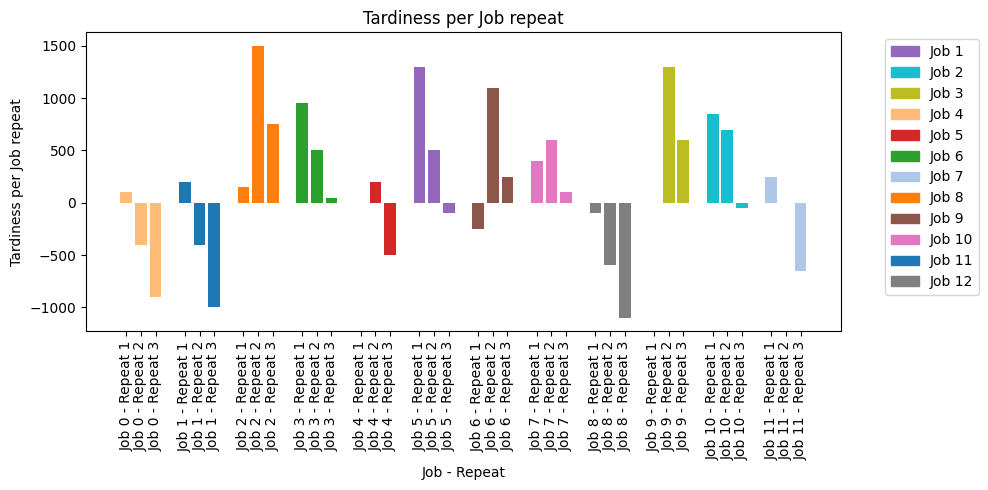

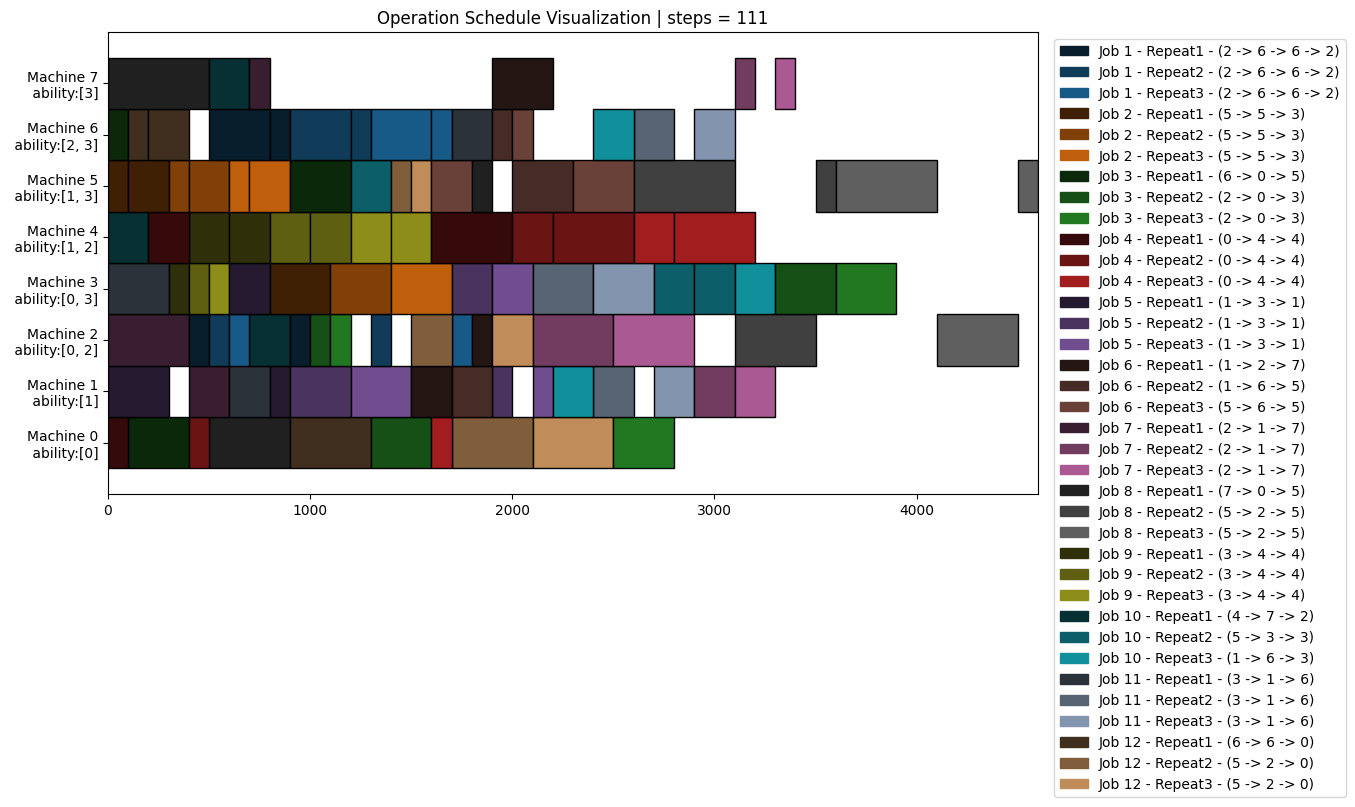

Current Repeats			:	[2, 2, 3, 3, 1, 4, 4, 3, 2, 2, 2, 4]
Goal reached! Final score	:	45.87
Total revenue			:	2180.00 - 1180.00 = 1000.00
Sum of Costs			:	1180.00
Cost Deadline			:	320.00
Cost Hole			:	34.00
Cost Processing			:	436.00
Cost Makespan			:	390.00
Finish Time / Target Time	:	3900 / 2725
Average Tardiness:	-70.31


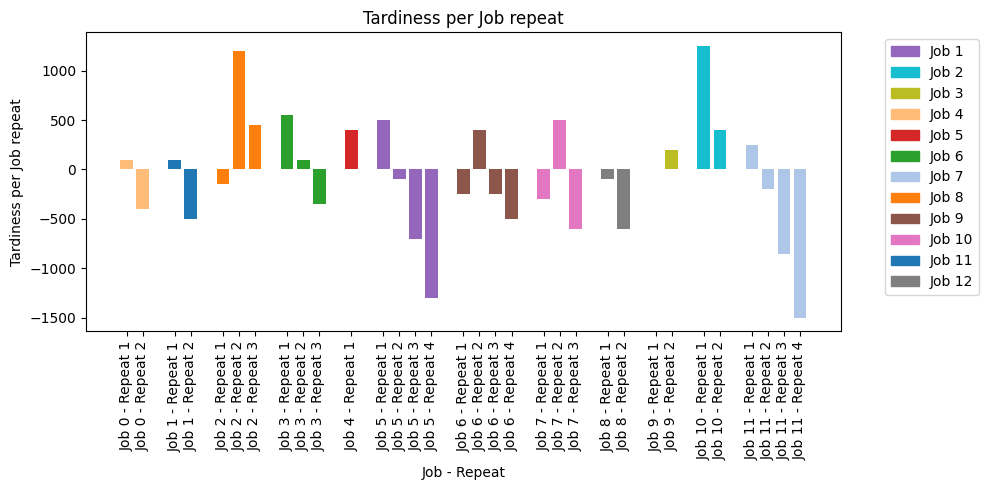

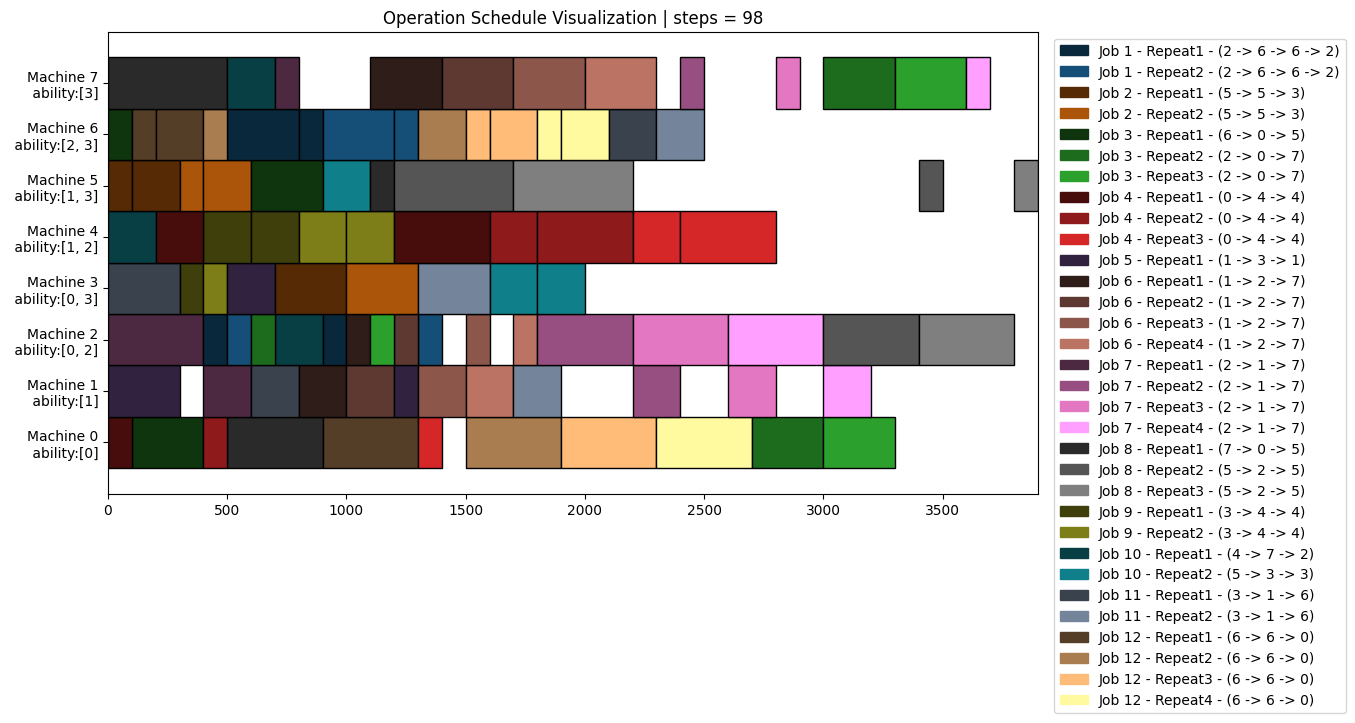

In [14]:
for env in custom_env:
    obs, info = env.reset()
    while True:
        action, _ = model.predict(obs, deterministic = True, action_masks = env.action_masks())
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        if done:
            # print("Goal reached!", "final score=", reward)
            # print('job_deadline', info['job_deadline'])
            # print('job_time_exceeded', info['job_time_exceeded'])
            # print('current_repeats', info['current_repeats'])
            # print(env.target_time)
            info["reward"] = reward
            info["env"] = env
            info["profit_ratio"] = env.profit_per_time
            env.print_result(info, detail_mode = False)
            env.render()
            break

In [11]:
model.save("PPO_random_repeat")